In [1]:
import pandas as pd
import numpy as np
import math
import json

from pprint import pprint
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report, r2_score, precision_score

import seaborn as sns

## Load in DataFrame created in the data_aggregation notebook

In [2]:

enriched_dtevent = pd.read_csv('enriched_dtevent.csv')
pd.set_option('display.max_columns', None)
enriched_dtevent

,person,offer_id,viewed_dt_mean,completed_dt_mean,viewed_count,completed_count,completed,gender,age,became_member_on,income,gender_encoded,membership_startdate,reward,difficulty,duration,offer_type,ch_mobile,ch_web,ch_social,ch_email,ot_bogo,ot_discount,ot_informational,offer_type_encoded
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.500000,NaN,1.0,NaN,0,M,33,20170421,72000.0,1,2017-04-21,0,0,4,informational,1,1,0,1,0,0,1,2
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.000000,NaN,1.0,NaN,0,M,33,20170421,72000.0,1,2017-04-21,0,0,3,informational,1,0,1,1,0,0,1,2
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,2.000000,NaN,1.0,NaN,0,M,33,20170421,72000.0,1,2017-04-21,5,5,5,bogo,1,1,1,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.500000,NaN,1.0,NaN,0,M,33,20170421,72000.0,1,2017-04-21,2,10,10,discount,1,1,1,1,0,1,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.000000,6.000000,1.0,1.0,1,O,40,20180109,57000.0,2,2018-01-09,5,20,10,discount,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42334,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2.250000,0.750000,2.0,2.0,1,M,34,20170123,34000.0,1,2017-01-23,5,5,5,bogo,1,1,1,1,1,0,0,0
42335,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.250000,1.000000,1.0,1.0,1,F,45,20161125,62000.0,0,2016-11-25,5,20,10,discount,0,1,0,1,0,1,0,1
42336,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,0.416667,2.666667,3.0,3.0,1,F,45,20161125,62000.0,0,2016-11-25,2,10,7,discount,1,1,0,1,0,1,0,1
42337,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.250000,NaN,1.0,NaN,0,F,45,20161125,62000.0,0,2016-11-25,5,5,7,bogo,1,1,0,1,1,0,0,0


# Model Evaluation

In [3]:
# any null values?
# - yes
enriched_dtevent.isnull().any()

person                  False
offer_id                False
viewed_dt_mean           True
completed_dt_mean        True
viewed_count             True
completed_count          True
completed               False
gender                  False
age                     False
became_member_on        False
income                  False
gender_encoded          False
membership_startdate    False
reward                  False
difficulty              False
duration                False
offer_type              False
ch_mobile               False
ch_web                  False
ch_social               False
ch_email                False
ot_bogo                 False
ot_discount             False
ot_informational        False
offer_type_encoded      False
dtype: bool

In [4]:
# convert any nans we might use later during regression...
enriched_dtevent['completed'] = enriched_dtevent.completed.replace(np.nan, 0)

# no informational offer events
enriched_dtevent = enriched_dtevent[enriched_dtevent.offer_type_encoded != 2]

enriched_dtevent

,person,offer_id,viewed_dt_mean,completed_dt_mean,viewed_count,completed_count,completed,gender,age,became_member_on,income,gender_encoded,membership_startdate,reward,difficulty,duration,offer_type,ch_mobile,ch_web,ch_social,ch_email,ot_bogo,ot_discount,ot_informational,offer_type_encoded
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,2.000000,NaN,1.0,NaN,0,M,33,20170421,72000.0,1,2017-04-21,5,5,5,bogo,1,1,1,1,1,0,0,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.500000,NaN,1.0,NaN,0,M,33,20170421,72000.0,1,2017-04-21,2,10,10,discount,1,1,1,1,0,1,0,1
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.000000,6.000000,1.0,1.0,1,O,40,20180109,57000.0,2,2018-01-09,5,20,10,discount,0,1,0,1,0,1,0,1
5,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,0.750000,2.750000,1.0,1.0,1,O,40,20180109,57000.0,2,2018-01-09,3,7,7,discount,1,1,1,1,0,1,0,1
8,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.500000,2.500000,1.0,1.0,1,O,40,20180109,57000.0,2,2018-01-09,5,5,7,bogo,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42334,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2.250000,0.750000,2.0,2.0,1,M,34,20170123,34000.0,1,2017-01-23,5,5,5,bogo,1,1,1,1,1,0,0,0
42335,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.250000,1.000000,1.0,1.0,1,F,45,20161125,62000.0,0,2016-11-25,5,20,10,discount,0,1,0,1,0,1,0,1
42336,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,0.416667,2.666667,3.0,3.0,1,F,45,20161125,62000.0,0,2016-11-25,2,10,7,discount,1,1,0,1,0,1,0,1
42337,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.250000,NaN,1.0,NaN,0,F,45,20161125,62000.0,0,2016-11-25,5,5,7,bogo,1,1,0,1,1,0,0,0


In [5]:
## transform high and variable income values into fewer categorical values:
#le = LabelEncoder()
#income_cats = pd.cut(enriched_dtevent.income, 2, labels=['low', 'very high'],retbins=True)[0]
#enriched_dtevent['income_bins_encoded'] = le.fit_transform(income_cats)
## transform high and variable age values into fewer categorical values:
#le = LabelEncoder()
#age_cuts = pd.cut(enriched_dtevent.age, 5, labels=['low', 'moderate' ,'considerable', 'high', 'very high'],retbins=True)[0]
#enriched_dtevent['age_bins_encoded'] = le.fit_transform(age_cuts)

#enriched_dtevent

In [6]:
#define target vector
y = enriched_dtevent[['completed']]

1    34371
Name: ch_email, dtype: int64

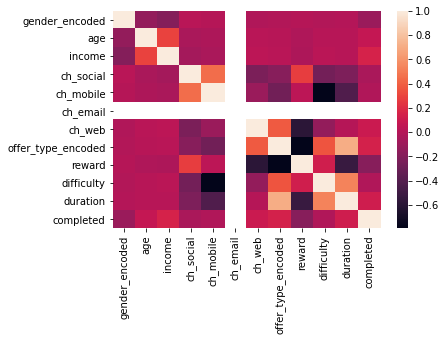

In [7]:

def correlation_heatmap(X,y):
    '''
    Description: creates a heatmap from the correlation of the matrix X combined with target vector y
    '''
    df_heat = pd.concat([ pd.DataFrame(X), pd.DataFrame(y)], axis=1)
    df_heat.columns = list(X.columns) +  ["completed"]
    sns.heatmap(df_heat.corr())

feature_columns = ['gender_encoded','age','income','ch_social','ch_mobile','ch_email','ch_web','offer_type_encoded','reward', 'difficulty', 'duration']
correlation_heatmap(enriched_dtevent[feature_columns],y)
# values are near zero => No linear relationship  :-(
enriched_dtevent['ch_email'].value_counts()
# email is always 1. do not consider

In [8]:
# derive feature matrix and target vector from input data for prediction
X = enriched_dtevent[['gender_encoded','age','income','ch_social','ch_mobile','ch_email','ch_web','offer_type_encoded']]

X = enriched_dtevent[['gender_encoded','age','income','ch_social','ch_mobile','ch_web','offer_type_encoded','reward', 'difficulty', 'duration']]
#X = enriched_dtevent[['income','ch_social','ch_mobile','ch_web','offer_type_encoded', 'duration','difficulty']]

display(X,y)

,gender_encoded,age,income,ch_social,ch_mobile,ch_web,offer_type_encoded,reward,difficulty,duration
2,1,33,72000.0,1,1,1,0,5,5,5
3,1,33,72000.0,1,1,1,1,2,10,10
4,2,40,57000.0,0,0,1,1,5,20,10
5,2,40,57000.0,1,1,1,1,3,7,7
8,2,40,57000.0,0,1,1,0,5,5,7
...,...,...,...,...,...,...,...,...,...,...
42334,1,34,34000.0,1,1,1,0,5,5,5
42335,0,45,62000.0,0,0,1,1,5,20,10
42336,0,45,62000.0,0,1,1,1,2,10,7
42337,0,45,62000.0,0,1,1,0,5,5,7


,completed
2,0
3,0
4,1
5,1
8,1
...,...
42334,1
42335,1
42336,1
42337,0


In [9]:
# split data set in to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)
# scale data set values between [0;1]
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)  # fit and transform
#X_test = scaler.transform(X_test)  # transform


In [10]:
from itertools import chain, combinations

def powerset(iterable):
    '''
    Description: create all possible subsets of an iterable
                 code snipet is a recipe from https://docs.python.org/3/library/itertools.html
    Argument iterable: e.g. [1,2,3]
    Returns: all possible subsets. E.g. (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    '''
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


## Linear Regression model

In [11]:
def fit_pipeline(pipeline, feature_index_set, X_train, X_test, y_train, y_test):
    '''
    Description: fit a scikit pipeline for multiple columns subsets
    Arguments:
       pipeline: scikit-learn pipeline
       feature_index_set: list of list of numbers. each list contains the indices to choose columns from
                          X_test and X_train
       X_train, X_test, y_train, y_test: result values from scikit's train_test_split function
    Returns: a pandas DataFrame with train and test scores for each fitted subset of the input data.
             If the pipeline was of type GridSearchCV the last column contains the best found params
             for the model used.
    '''
    feature_accuracy = []
    for cn in feature_index_set:
        if len(cn) == 0:
            continue
        fm_train = X_train.iloc[:,list(cn)] # select subset defined by the feature_index
        fm_test = X_test.iloc[:,list(cn)]
        #print("fitting features: " + ",".join([X_train.columns[index] for index in list(cn)]))
        print("fitting feature set: " + str(list(cn)))
        pipeline.fit(fm_train,y_train)
        train_score = precision_score(y_train,pipeline.predict(fm_train).round())
        test_score = precision_score(y_test, pipeline.predict(fm_test).round())
        feature_accuracy.append([len(cn),cn, train_score, test_score, getattr(pipeline, 'best_params_', 'none')])     
        
    df = pd.DataFrame(feature_accuracy, columns=['num_features','feature_index_set','train_score', 'test_score', 'best_params'])
    df = df.set_index('num_features')
    df = df.sort_values(by='test_score', ascending=False)
    return df

pipeline = Pipeline(steps=[('normalize', MinMaxScaler()),('model',LinearRegression())])
feature_index_set = list(powerset(np.arange(0,X_train.shape[1],1))) # cartesian product
#feature_index_set = [list(range(0,i,1)) for i in range(1,X_train.shape[1]+1,1)] + [[0, 2, 4, 5, 6, 7]]
lg_result = fit_pipeline(pipeline, feature_index_set, X_train, X_test, y_train, y_test)


fitting feature set: [0]
fitting feature set: [1]
fitting feature set: [2]
fitting feature set: [3]
fitting feature set: [4]
fitting feature set: [5]
fitting feature set: [6]
fitting feature set: [7]
fitting feature set: [8]
fitting feature set: [9]
fitting feature set: [0, 1]
fitting feature set: [0, 2]
fitting feature set: [0, 3]
fitting feature set: [0, 4]
fitting feature set: [0, 5]
fitting feature set: [0, 6]
fitting feature set: [0, 7]
fitting feature set: [0, 8]
fitting feature set: [0, 9]
fitting feature set: [1, 2]
fitting feature set: [1, 3]
fitting feature set: [1, 4]
fitting feature set: [1, 5]
fitting feature set: [1, 6]
fitting feature set: [1, 7]
fitting feature set: [1, 8]
fitting feature set: [1, 9]
fitting feature set: [2, 3]
fitting feature set: [2, 4]
fitting feature set: [2, 5]
fitting feature set: [2, 6]
fitting feature set: [2, 7]
fitting feature set: [2, 8]
fitting feature set: [2, 9]
fitting feature set: [3, 4]
fitting feature set: [3, 5]
fitting feature set: [

fitting feature set: [1, 2, 3, 9]
fitting feature set: [1, 2, 4, 5]
fitting feature set: [1, 2, 4, 6]
fitting feature set: [1, 2, 4, 7]
fitting feature set: [1, 2, 4, 8]
fitting feature set: [1, 2, 4, 9]
fitting feature set: [1, 2, 5, 6]
fitting feature set: [1, 2, 5, 7]
fitting feature set: [1, 2, 5, 8]
fitting feature set: [1, 2, 5, 9]
fitting feature set: [1, 2, 6, 7]
fitting feature set: [1, 2, 6, 8]
fitting feature set: [1, 2, 6, 9]
fitting feature set: [1, 2, 7, 8]
fitting feature set: [1, 2, 7, 9]
fitting feature set: [1, 2, 8, 9]
fitting feature set: [1, 3, 4, 5]
fitting feature set: [1, 3, 4, 6]
fitting feature set: [1, 3, 4, 7]
fitting feature set: [1, 3, 4, 8]
fitting feature set: [1, 3, 4, 9]
fitting feature set: [1, 3, 5, 6]
fitting feature set: [1, 3, 5, 7]
fitting feature set: [1, 3, 5, 8]
fitting feature set: [1, 3, 5, 9]
fitting feature set: [1, 3, 6, 7]
fitting feature set: [1, 3, 6, 8]
fitting feature set: [1, 3, 6, 9]
fitting feature set: [1, 3, 7, 8]
fitting featur

fitting feature set: [0, 4, 5, 6, 9]
fitting feature set: [0, 4, 5, 7, 8]
fitting feature set: [0, 4, 5, 7, 9]
fitting feature set: [0, 4, 5, 8, 9]
fitting feature set: [0, 4, 6, 7, 8]
fitting feature set: [0, 4, 6, 7, 9]
fitting feature set: [0, 4, 6, 8, 9]
fitting feature set: [0, 4, 7, 8, 9]
fitting feature set: [0, 5, 6, 7, 8]
fitting feature set: [0, 5, 6, 7, 9]
fitting feature set: [0, 5, 6, 8, 9]
fitting feature set: [0, 5, 7, 8, 9]
fitting feature set: [0, 6, 7, 8, 9]
fitting feature set: [1, 2, 3, 4, 5]
fitting feature set: [1, 2, 3, 4, 6]
fitting feature set: [1, 2, 3, 4, 7]
fitting feature set: [1, 2, 3, 4, 8]
fitting feature set: [1, 2, 3, 4, 9]
fitting feature set: [1, 2, 3, 5, 6]
fitting feature set: [1, 2, 3, 5, 7]
fitting feature set: [1, 2, 3, 5, 8]
fitting feature set: [1, 2, 3, 5, 9]
fitting feature set: [1, 2, 3, 6, 7]
fitting feature set: [1, 2, 3, 6, 8]
fitting feature set: [1, 2, 3, 6, 9]
fitting feature set: [1, 2, 3, 7, 8]
fitting feature set: [1, 2, 3, 7, 9]
f

fitting feature set: [0, 2, 3, 4, 7, 9]
fitting feature set: [0, 2, 3, 4, 8, 9]
fitting feature set: [0, 2, 3, 5, 6, 7]
fitting feature set: [0, 2, 3, 5, 6, 8]
fitting feature set: [0, 2, 3, 5, 6, 9]
fitting feature set: [0, 2, 3, 5, 7, 8]
fitting feature set: [0, 2, 3, 5, 7, 9]
fitting feature set: [0, 2, 3, 5, 8, 9]
fitting feature set: [0, 2, 3, 6, 7, 8]
fitting feature set: [0, 2, 3, 6, 7, 9]
fitting feature set: [0, 2, 3, 6, 8, 9]
fitting feature set: [0, 2, 3, 7, 8, 9]
fitting feature set: [0, 2, 4, 5, 6, 7]
fitting feature set: [0, 2, 4, 5, 6, 8]
fitting feature set: [0, 2, 4, 5, 6, 9]
fitting feature set: [0, 2, 4, 5, 7, 8]
fitting feature set: [0, 2, 4, 5, 7, 9]
fitting feature set: [0, 2, 4, 5, 8, 9]
fitting feature set: [0, 2, 4, 6, 7, 8]
fitting feature set: [0, 2, 4, 6, 7, 9]
fitting feature set: [0, 2, 4, 6, 8, 9]
fitting feature set: [0, 2, 4, 7, 8, 9]
fitting feature set: [0, 2, 5, 6, 7, 8]
fitting feature set: [0, 2, 5, 6, 7, 9]
fitting feature set: [0, 2, 5, 6, 8, 9]


fitting feature set: [0, 2, 3, 5, 6, 8, 9]
fitting feature set: [0, 2, 3, 5, 7, 8, 9]
fitting feature set: [0, 2, 3, 6, 7, 8, 9]
fitting feature set: [0, 2, 4, 5, 6, 7, 8]
fitting feature set: [0, 2, 4, 5, 6, 7, 9]
fitting feature set: [0, 2, 4, 5, 6, 8, 9]
fitting feature set: [0, 2, 4, 5, 7, 8, 9]
fitting feature set: [0, 2, 4, 6, 7, 8, 9]
fitting feature set: [0, 2, 5, 6, 7, 8, 9]
fitting feature set: [0, 3, 4, 5, 6, 7, 8]
fitting feature set: [0, 3, 4, 5, 6, 7, 9]
fitting feature set: [0, 3, 4, 5, 6, 8, 9]
fitting feature set: [0, 3, 4, 5, 7, 8, 9]
fitting feature set: [0, 3, 4, 6, 7, 8, 9]
fitting feature set: [0, 3, 5, 6, 7, 8, 9]
fitting feature set: [0, 4, 5, 6, 7, 8, 9]
fitting feature set: [1, 2, 3, 4, 5, 6, 7]
fitting feature set: [1, 2, 3, 4, 5, 6, 8]
fitting feature set: [1, 2, 3, 4, 5, 6, 9]
fitting feature set: [1, 2, 3, 4, 5, 7, 8]
fitting feature set: [1, 2, 3, 4, 5, 7, 9]
fitting feature set: [1, 2, 3, 4, 5, 8, 9]
fitting feature set: [1, 2, 3, 4, 6, 7, 8]
fitting fea

,feature_index_set,train_score,test_score,best_params
num_features,,,,
7,"(0, 1, 2, 3, 6, 8, 9)",0.653907,0.654911,none
5,"(0, 1, 2, 6, 8)",0.653874,0.654579,none
6,"(0, 1, 2, 6, 8, 9)",0.654186,0.654562,none
5,"(0, 2, 6, 8, 9)",0.653268,0.654354,none
6,"(0, 2, 3, 6, 8, 9)",0.653957,0.654352,none
...,...,...,...,...
2,"(0, 3)",0.584863,0.587915,none
3,"(0, 3, 8)",0.584863,0.587915,none
2,"(0, 8)",0.584863,0.587915,none


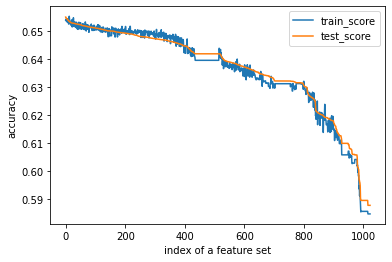

In [12]:
def display_pipeline_result(df):
    display(df)
    df = df.reset_index()
    plot = df[['train_score','test_score']].plot()
    plot.set_xlabel("index of a feature set")
    plot.set_ylabel("accuracy")
    plt.show()
    
    #sns.boxplot(data=df, x="num_features", y="train_score", color='red')
    #sns.boxplot(data=df, x="num_features", y="test_score", color='blue')
display_pipeline_result(lg_result)

In [13]:
# best features so far:
#",".join
str([X.columns[index] for index in list(lg_result.iloc[0].feature_index_set)])


"['gender_encoded', 'age', 'income', 'ch_social', 'offer_type_encoded', 'difficulty', 'duration']"

In [14]:
model = RadiusNeighborsClassifier()
params = {'model__radius': np.arange(0.5, 1.2, 0.5),
             'model__weights': ['uniform', 'distance'],
         'model__leaf_size': [20,30,40]}
pipeline = Pipeline(steps=[('normalize', MinMaxScaler()),('model',model)])
grid = GridSearchCV(pipeline, params, cv=None, scoring=make_scorer(score_func=precision_score, greater_is_better=True), verbose=10, n_jobs=3)
feature_index_set = [(0, 1, 2, 6, 8, 9)]
radius_acc = fit_pipeline(grid, feature_index_set, X_train, X_test, y_train.values.ravel(), y_test)
display(radius_acc.iloc[0])

fitting feature set: [0, 1, 2, 6, 8, 9]
Fitting 5 folds for each of 12 candidates, totalling 60 fits


feature_index_set                                   (0, 1, 2, 6, 8, 9)
train_score                                                   0.647375
test_score                                                    0.646526
best_params          {'model__leaf_size': 20, 'model__radius': 0.5,...
Name: 6, dtype: object

,feature_index_set,train_score,test_score,best_params
num_features,,,,
6,"(0, 1, 2, 6, 8, 9)",0.647375,0.646526,"{'model__leaf_size': 20, 'model__radius': 0.5,..."


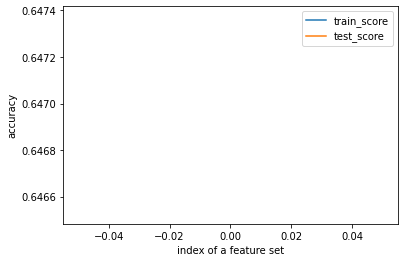

In [15]:
display_pipeline_result(radius_acc)
# RadiusNeighborsClassifier => accuracy: ~64%